In [1]:


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings



/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/mdshare/repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)
/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/util/log.py:64: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)
/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.5.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
pdb = '3base_traj_1.pdb'
files = ['3base_traj_%i.dcd'%d for d in range(1,47)]
print(files)

['3base_traj_1.dcd', '3base_traj_2.dcd', '3base_traj_3.dcd', '3base_traj_4.dcd', '3base_traj_5.dcd', '3base_traj_6.dcd', '3base_traj_7.dcd', '3base_traj_8.dcd', '3base_traj_9.dcd', '3base_traj_10.dcd', '3base_traj_11.dcd', '3base_traj_12.dcd', '3base_traj_13.dcd', '3base_traj_14.dcd', '3base_traj_15.dcd', '3base_traj_16.dcd', '3base_traj_17.dcd', '3base_traj_18.dcd', '3base_traj_19.dcd', '3base_traj_20.dcd', '3base_traj_21.dcd', '3base_traj_22.dcd', '3base_traj_23.dcd', '3base_traj_24.dcd', '3base_traj_25.dcd', '3base_traj_26.dcd', '3base_traj_27.dcd', '3base_traj_28.dcd', '3base_traj_29.dcd', '3base_traj_30.dcd', '3base_traj_31.dcd', '3base_traj_32.dcd', '3base_traj_33.dcd', '3base_traj_34.dcd', '3base_traj_35.dcd', '3base_traj_36.dcd', '3base_traj_37.dcd', '3base_traj_38.dcd', '3base_traj_39.dcd', '3base_traj_40.dcd', '3base_traj_41.dcd', '3base_traj_42.dcd', '3base_traj_43.dcd', '3base_traj_44.dcd', '3base_traj_45.dcd', '3base_traj_46.dcd']


In [3]:
# dihedral angles
diAT = [[19,20,23,24],[20,23,24,25],
                   [23,24,25,26],[24,25,26,27],
                   [25,26,27,38],[26,27,38,40],
                   [27,38,40,25],[38,40,25,24],
                   [24,25,40,41],[25,40,41,42],
                   [40,41,42,45],[26,27,28,35],      #upto here is A base
                   [83,84,87,88],[84,87,88,89],[87,88,89,90],[88,89,90,91],[89,90,91,100],
                   [90,91,100,102],[91,100,102,89],[100,102,89,88],[88,89,102,103],[89,102,103,104],
                   [102,103,104,108]] #upto here is U base
#Hydrogen bond distances
Hbond = [[37,98],[32,96],[30,96]]
feat = pyemma.coordinates.featurizer(pdb)
feat.add_dihedrals(diAT,cossin=False)
feat.add_distances(Hbond)
data = pyemma.coordinates.load(files, features=feat)

In [4]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores




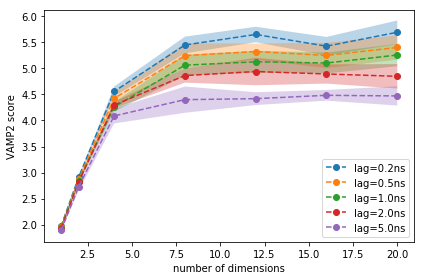

In [29]:
lags = [20, 50, 100, 200, 500]
dims = [i for i in [1, 2, 4, 8, 12, 16, 20]]
#dims = [1]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.01))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

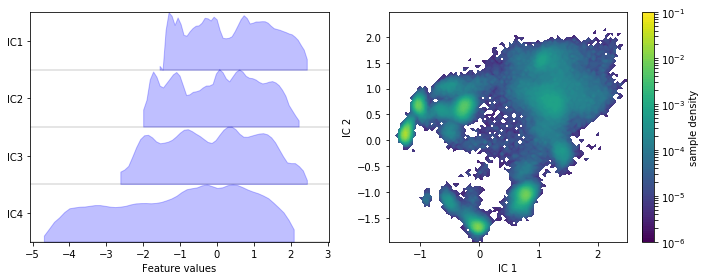

In [4]:
tica = pyemma.coordinates.tica(data, lag=200)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated[:, :4],
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

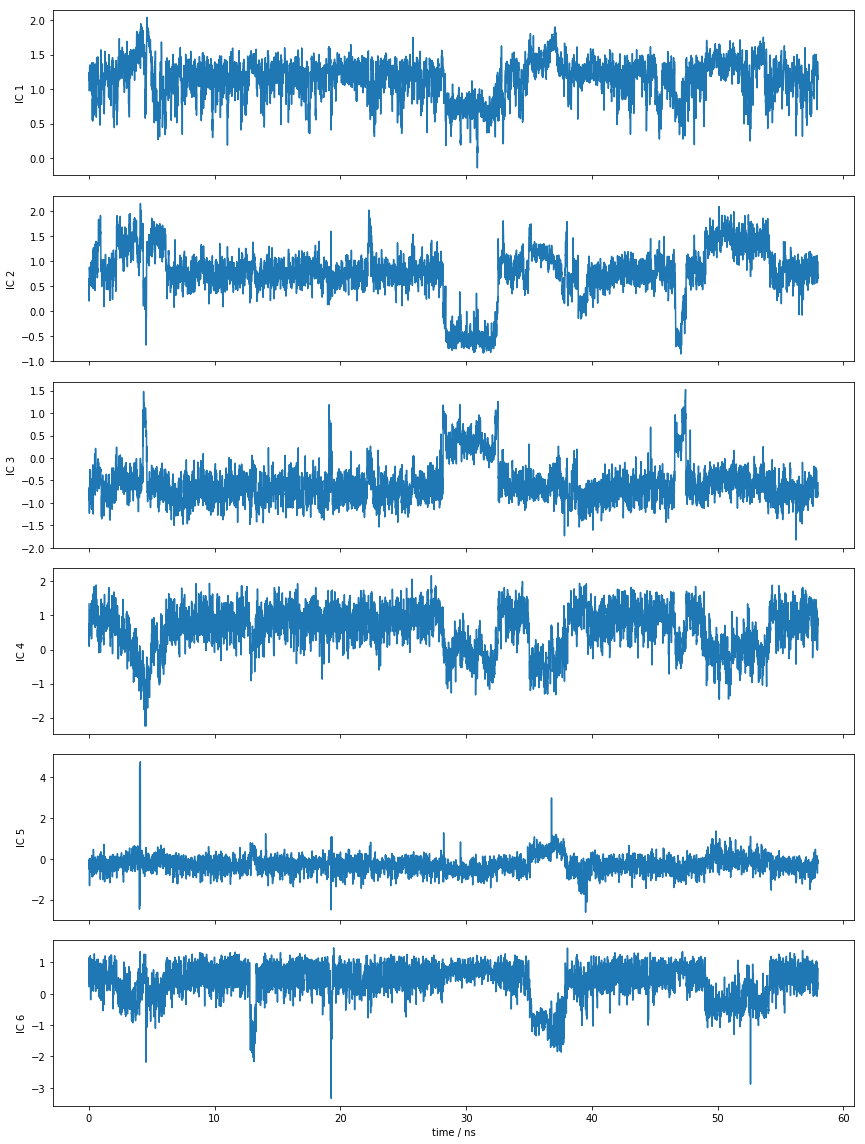

In [137]:
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)
x = 0.01 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
plt.savefig('TICA-trajectory.pdf')

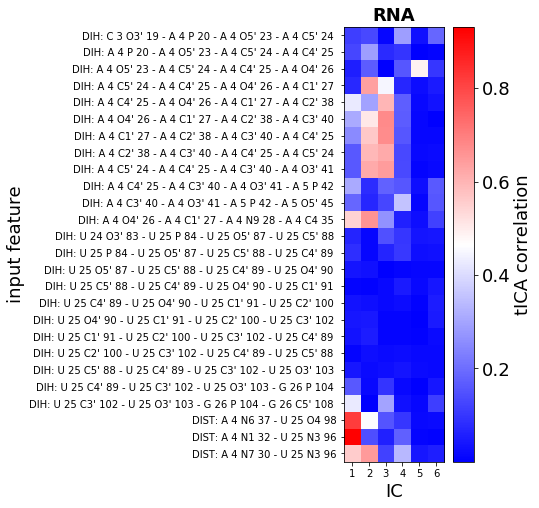

In [25]:
fig, ax = plt.subplots(figsize=(3, 8))
i = ax.imshow(abs(tica.feature_TIC_correlation), cmap='bwr',)

ax.set_xticks(range(tica.dimension()))
ax.set_xticklabels(range(1,tica.dimension()+1))
ax.set_xlabel('IC',fontsize=18)

ax.set_yticks(range(feat.dimension()))
ax.set_yticklabels(feat.describe())
ax.set_ylabel('input feature',fontsize=18)

#secax = ax.secondary_yaxis('right')
#secax.set_ylabel('tICA correlation')
#ax.tick_params(labelsize=16)
cbar=fig.colorbar(i);
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel('tICA correlation',fontsize=18)
plt.title('RNA',fontsize=18,fontweight='bold')
plt.savefig('tica.pdf',bbox_inches='tight')
#print(tica.feature_TIC_correlation)

In [7]:
n_clustercenters = [20, 30, 40, 50, 60, 80, 100, 200, 400]

scores = np.zeros((len(n_clustercenters), 10))
for n, k in enumerate(n_clustercenters):
    for m in range(10):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 1000)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

KeyboardInterrupt: 

In [11]:
print(scores)

[[3.12783569 3.62229355 3.04665015 3.34166003 2.84970031]
 [4.95746609 4.42723884 4.71739946 5.04800494 4.61280562]
 [4.67511768 5.32406505 3.82196508 4.77928745 5.39123452]
 [5.17288834 5.6665039  5.71427587 5.21986375 5.68040053]
 [5.33588416 5.54828058 5.21911275 5.56230123 4.41260578]
 [5.40006795 5.66258736 4.61175794 5.26594255 5.68173223]
 [4.4343096  5.46338198 4.38626156 4.86946214 3.3869931 ]
 [4.94048012 5.85364369 4.54554745 4.50222799 5.11477029]]


In [64]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=200, max_iter=50, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

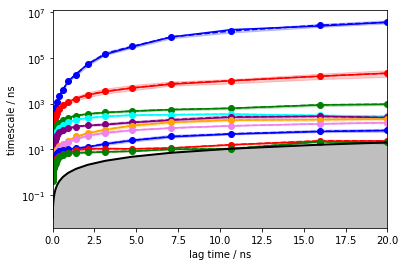

In [65]:

its = pyemma.msm.its(cluster.dtrajs, lags=2000, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.01, ylog=True)
#plt.savefig('Implied-timescales.pdf')

In [79]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=700, dt_traj='0.01 ns')


/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


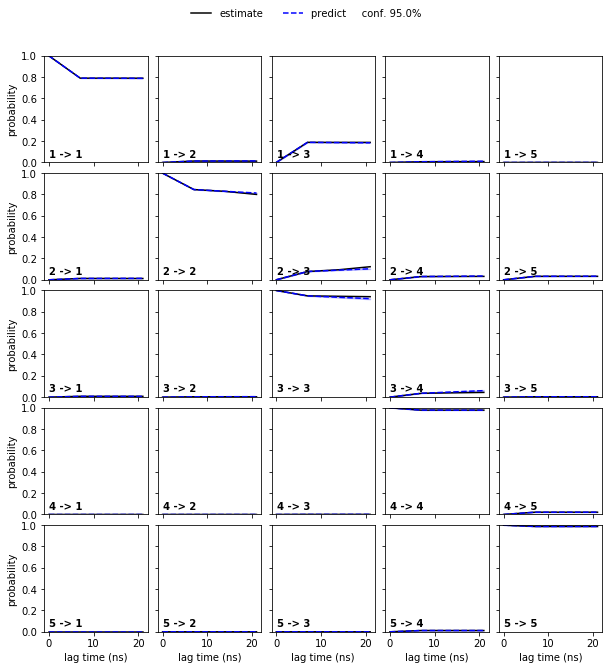

In [81]:
nstates = 5
cktest = msm.cktest(nstates, mlags=4)
pyemma.plots.plot_cktest(cktest, dt=0.01, units='ns');

#plt.savefig('CKTest.pdf')

In [96]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=700, dt_traj='0.01 ns')

In [72]:
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


#save the data in a file so that we can call it back
cluster.save('dihedral.pyemma',model_name='dihedral-cluster',overwrite=True)
msm.save('dihedral.pyemma',model_name='dihedral-msm',overwrite=True)
tica.save('dihedral.pyemma',model_name='dihedral-tica',overwrite=True)

In [5]:
#import saved data
msm = pyemma.load('dihedral.pyemma',model_name='dihedral-msm')
cluster = pyemma.load('dihedral.pyemma',model_name='dihedral-cluster')
tica = pyemma.load('dihedral.pyemma',model_name='dihedral-tica')
#tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

/home/dhiman/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [60]:
tica

TICA(commute_map=False, dim=-1, epsilon=1e-06, kinetic_map=True, lag=200,
   ncov_max=inf, reversible=True, skip=100, stride=1, var_cutoff=0.95,
   weights=None)

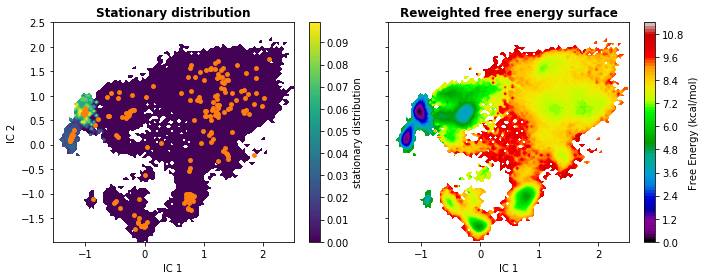

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False, kT=0.6, cbar_label='Free Energy (kcal/mol)')
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
axes[0].scatter(*cluster.clustercenters[:,:2].T, s = 15, c='C1')
fig.tight_layout()
#plt.savefig('Free-Energy.pdf')

The first eigenvector is one: True (min=0.9999999997929456, max=1.000000000095188)


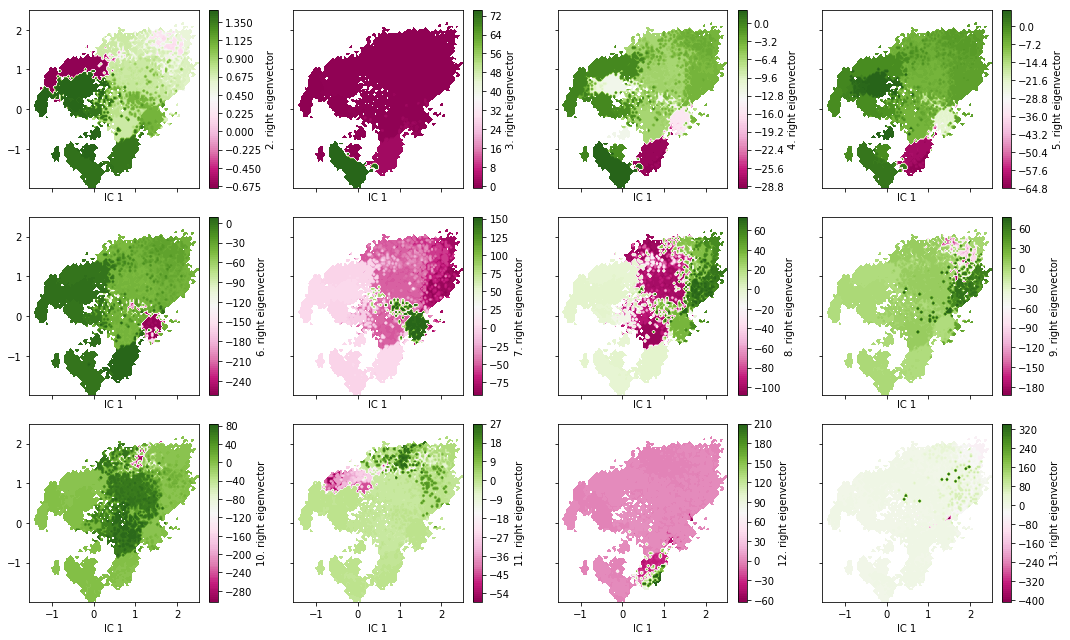

In [85]:


eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
#axes[0].set_ylabel('IC 2')
fig.tight_layout()



In [6]:
nstates = 4
msm.pcca(nstates)

PCCA(P=array([[0.02467, 0.     , ..., 0.     , 0.00134],
       [0.     , 0.09128, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.01746, 0.     ],
       [0.00209, 0.     , ..., 0.     , 0.01201]]),
   m=4)

In [97]:
#save the data in a file so that we can call it back
#cluster.save('dihedral.pyemma',model_name='dihedral-cluster',overwrite=True)
#msm.save('dihedral.pyemma',model_name='dihedral-msm',overwrite=True)
#tica.save('dihedral.pyemma',model_name='dihedral-tica',overwrite=True)

30-06-19 17:19:51 pyemma._base.serialization.h5file INFO     overwriting model "dihedral-cluster" in file dihedral.pyemma
30-06-19 17:19:51 pyemma._base.serialization.h5file INFO     overwriting model "dihedral-msm" in file dihedral.pyemma
30-06-19 17:19:52 pyemma._base.serialization.h5file INFO     overwriting model "dihedral-tica" in file dihedral.pyemma


In [98]:
#import saved data
msm = pyemma.load('dihedral.pyemma',model_name='dihedral-msm')
cluster = pyemma.load('dihedral.pyemma',model_name='dihedral-cluster')
#tica = pyemma.load('dihedral.pyemma',model_name='dihedral-tica')
#tica_output = tica.get_output()
#tica_concatenated = np.concatenate(tica_output)

IndexError: index 3 is out of bounds for axis 0 with size 3

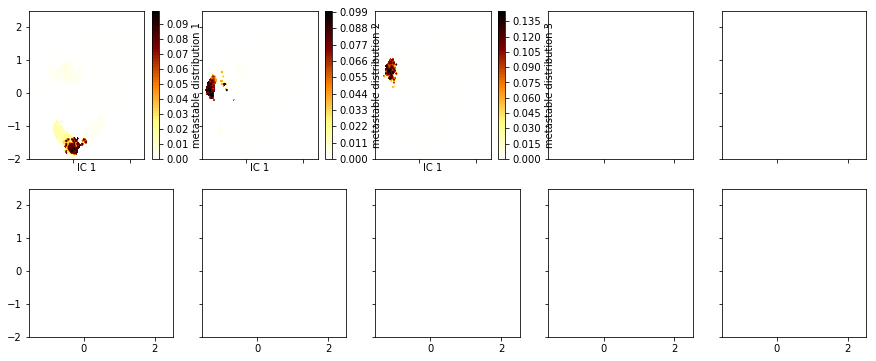

In [102]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
#a.set_ylabel('IC 2')
fig.tight_layout()

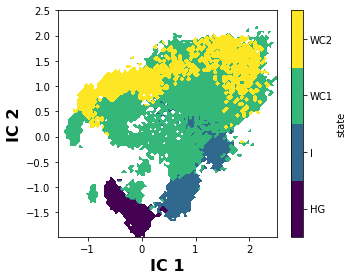

In [113]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]


tic1 = 1
tic2 = 2

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, ((tic1-1),(tic2-1))].T, metastable_traj, ax=ax)
ax.set_xlabel('IC %d'%tic1,fontsize=16,fontweight='bold')
ax.set_ylabel('IC %d'%tic2,fontsize=16,fontweight='bold')
misc['cbar'].set_ticklabels(['HG','I','WC1','WC2'])
fig.tight_layout()
plt.savefig('states.pdf')

In [108]:
start, final = 0,3
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

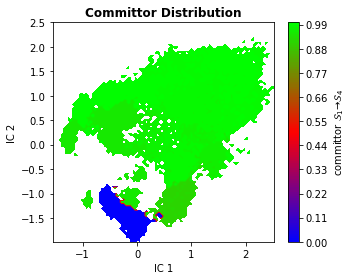

In [109]:
fig, ax = plt.subplots(figsize=(5, 4))

tic1 = 1
tic2 = 2

pyemma.plots.plot_contour(
    *tica_concatenated[:, ((tic1-1),(tic2-1))].T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor $\mathcal{S}_{%d} \to \mathcal{S}_%d$' % (
        start + 1, final + 1))
ax.set_xlabel('IC %d'%tic1)
ax.set_ylabel('IC %d'%tic2)
ax.set_title('Committor Distribution', fontweight='bold')
fig.tight_layout()
#plt.savefig('committor.pdf')

In [24]:
a = np.sort(flux.committor)
a

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.27499417e-04, 1.29293429e-04, 1.30836269e-04, 1.30953625e-04,
       1.32163841e-04, 1.32477288e-04, 1.32708969e-04, 1.33982474e-04,
       1.34598562e-04, 1.35443681e-04, 1.35585568e-04, 1.55527872e-04,
       1.63706808e-04, 1.66558356e-04, 1.95076749e-04, 1.98068519e-04,
       1.99081890e-04, 2.01174105e-04, 2.01626907e-04, 2.01762020e-04,
       2.02325134e-04, 2.02504572e-04, 2.03231009e-04, 2.03245358e-04,
       2.03328714e-04, 2.03360550e-04, 2.03372981e-04, 2.03514590e-04,
       2.03617476e-04, 2.03655453e-04, 2.03762860e-04, 2.03786175e-04,
       2.03939179e-04, 2.04020390e-04, 2.04033712e-04, 2.04043546e-04,
       2.04266865e-04, 2.04304513e-04, 2.04417658e-04, 2.04437753e-04,
       2.04449844e-04, 2.06120636e-04, 2.08131270e-04, 2.39885337e-04,
      

In [106]:
from itertools import product
#nstates=50

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,214353.46,10614.59,599284.15
2,36795571.12,0.00,6195.51,577168.55
3,38105623.84,1424519.85,0.00,639378.15
4,40582004.31,3799906.76,1749188.54,0.00


[[0.00000000e+00 4.66519189e-06 9.42099644e-05 1.66865752e-06]
 [2.71771838e-08 0.00000000e+00 1.61407270e-04 1.73259614e-06]
 [2.62428455e-08 7.01990919e-07 0.00000000e+00 1.56401967e-06]
 [2.46414640e-08 2.63164352e-07 5.71693661e-07 0.00000000e+00]]


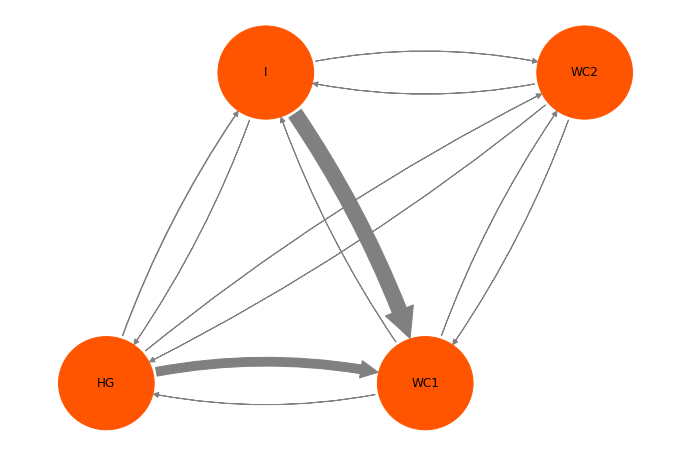

In [9]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

print(inverse_mfpt)

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [2, 4], [4, 0], [6, 4]]),
    #coarse_state_centers,
    arrow_label_format='%.2e /ns',
    arrow_labels=None,
    arrow_scale=3.0,
    state_labels=['HG','I','WC1','WC2'],
    size=12);
plt.savefig('network.pdf')

In [109]:
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [10]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 100)
torsions_source = pyemma.coordinates.source(files, features=feat)
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=['pcca{}_4states_100samples_tica-2ns.pdb'.format(n + 1)
              for n in range(msm.n_metastable)])

['pcca1_4states_100samples_tica-2ns.pdb',
 'pcca2_4states_100samples_tica-2ns.pdb',
 'pcca3_4states_100samples_tica-2ns.pdb',
 'pcca4_4states_100samples_tica-2ns.pdb']

In [108]:
#flux.major_flux(fraction=0.5)
flux.gross_flux.size


6400

In [114]:
paths, path_fluxes = cgflux.pathways(fraction=0.95)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

percentage       	path
-------------------------------------
0.84  	 [1 2 3 4]
0.16  	 [1 3 4]


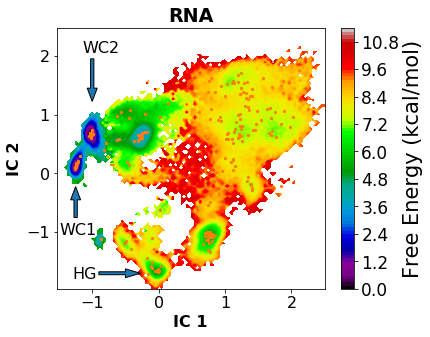

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(6,4.8), sharex=True, sharey=True)

_, _, misc = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes,
    kT=0.6,
    cbar_label='Free Energy (kcal/mol)',
    legacy=False)
axes.set_xlabel('IC 1',fontsize=16,fontweight='bold')
axes.set_ylabel('IC 2',fontsize=16,fontweight='bold')
#axes.set_title('Reweighted free energy surface', fontsize=16,fontweight='bold')
axes.scatter(*cluster.clustercenters[:,:2].T, s = 5, c='C1')
axes.set_xticks([2,1,0,-1])
axes.set_yticks([2,1,0,-1])
axes.tick_params(labelsize=16)
misc['cbar'].ax.tick_params(labelsize=17)
misc['cbar'].ax.set_ylabel('Free Energy (kcal/mol)',fontsize=21)
plt.arrow(-1.0,1.95,0.0,-0.5,width=0.05)
plt.text(-1.15, 2.05, 'WC2',fontsize=16)
plt.arrow(-1.25,-0.75,0.0,0.3,width=0.05)
plt.text(-1.5, -1.05, 'WC1',fontsize=16)
plt.arrow(-0.9,-1.7, 0.4, 0.0, width=0.05)
plt.text(-1.3, -1.8, 'HG',fontsize=16)
plt.title('RNA',weight='bold',fontsize=19)
plt.savefig('Free-energy.pdf')